# Group Details

## Group Name:

### Student 1:

### Student 2:

### Student 3:

# Loading Data and Preliminaries

In [123]:
# from google.colab import drive
# drive.mount('/content/drive')
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/data/"
notebook_dir = "data/"

In [124]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [125]:
# try:
#     import torch_geometric
# except:
#     !pip install torch_geometric
#     import torch_geometric

In [126]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [127]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example1 = load_array(notebook_dir+'data/task 1/train/trajectory_0.npz', task='task 1')

initial_state, terminal_state = example1
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [128]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example2 = load_array(notebook_dir+'data/task 2_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example2
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_array(notebook_dir+'data/task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Data Handling and Preprocessing

In [129]:
import os
import sys

t1_train = notebook_dir+'data/task 1/train/'
t1_test = notebook_dir+'data/task 1/test/'
t23_train = notebook_dir+'data/task 2_3/train/'
t23_test = notebook_dir+'data/task 2_3/test/'

t1_train_files = os.listdir(t1_train)
t1_test_files = os.listdir(t1_test)
t23_train_files = os.listdir(t23_train)
t23_test_files = os.listdir(t23_test)

In [130]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 1')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData(t1_train)
test_import = ImportData(t1_test)

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    padded_label = np.pad(label, ((0, pad_width), (0, 0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train_first = torch.tensor(np.array(X_train_padded))
y_train_first = torch.tensor(np.array(y_train_padded))
X_train = X_train_first[:700]
y_train = y_train_first[:700]
X_val = X_train_first[700:900]
y_val = y_train_first[700:900]
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))
print(y_train.shape)
X_train_ = X_train.view(700, -1)
y_train_ = y_train.view(700, -1)
X_val_ = X_val.view(200, -1)
y_val_ = y_val.view(200, -1)
X_test_ = X_test.view(100, -1)
y_test_ = y_test.view(100, -1)

# Print the shape of X_train and the first label in y_train
print("X_train shape: ", X_train_.shape)
print("y_train shape: ", y_train_.shape)
print("X_val shape: ", X_val_.shape)
print("y_val shape: ", y_val_.shape)
print("X_test shape: ", X_test_.shape)
print("y_test shape: ", y_test_.shape)

train_dataset = TensorDataset(X_train_, y_train_)
val_dataset = TensorDataset(X_val_, y_val_)
test_dataset = TensorDataset(X_test_, y_test_)

torch.Size([700, 9, 2])
X_train shape:  torch.Size([700, 45])
y_train shape:  torch.Size([700, 18])
X_val shape:  torch.Size([200, 45])
y_val shape:  torch.Size([200, 18])
X_test shape:  torch.Size([100, 45])
y_test shape:  torch.Size([100, 18])


# Model Implementation

In [131]:
X_train

tensor([[[ 4.5467, -5.2712,  5.0786, -1.0969, -3.6693],
         [ 3.5751,  4.3271, -0.0810, -0.5787, -2.9597],
         [ 2.6773, -5.1597,  5.3524,  2.4265,  1.4587],
         ...,
         [ 3.0312, -0.5056, 15.0463, -0.9477, 14.9813],
         [ 4.1353,  1.8134,  3.8438, -0.6990, -2.2509],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.6937,  2.0766,  1.0946, -1.1010, -2.2900],
         [ 1.8962, -3.1039, -4.7018, -1.2210,  0.6325],
         [ 2.7207,  4.9868, -5.2032, -1.1111, -0.1272],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000]],

        [[ 2.7304,  3.0285, -1.6972, -0.1030, -1.0698],
         [ 3.9471, -7.8725, -6.1954,  0.1767,  0.6270],
         [ 2.3910, -7.2830,  0.0613,  0.4682,  0.5501],
         ...,
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
  

In [168]:
from torch.nn import Linear
import torch.nn as nn
# from torch_geometric.nn import GCNConv
import torch.nn.functional as F

In [169]:
class LSTM_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=45, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 18)
#         self.batchnorm = nn.BatchNorm1d(50)
        
        
    def forward(self, x):
        x, _ = self.lstm(x)
#         x = self.batchnorm(x)
        x = F.leaky_relu(x)
#         x = F.tanh(x)
        x = self.linear(x)
        return x

# Model Training

In [170]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [171]:
def mean_distance_error(output, target):
    distance = []
    try:
        output = output.cpu().detach().numpy()
        target = target.cpu().numpy()
    except:
        pass
    for i in range(len(output)):
        for j in range(9):
            dist = np.linalg.norm(output[i][j] - target[i][j])
            distance.append(dist)
    return distance

In [182]:
#Make dataloader
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

model = LSTM_model()
model = model.float()
model = model.to(dev)
# print(model)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(20):
    model.train()
    train_loss = 0
    train_distances = []
    for x, y in train_dataloader:
        x, y = x.to(dev), y.to(dev)
        optimizer.zero_grad()  # Clear gradients.
        out = model(x.float())  # Perform a single forward pass.
        pred = out.view(len(x), -1, 2)
        truth = y.view(len(x), -1, 2)
        loss = criterion(pred.float(), truth.float())
        distance = mean_distance_error(pred, truth)
        train_distances.extend(distance)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        train_loss += loss/len(x)

    model.eval()
    val_loss = 0
    val_distances = []
    with torch.no_grad():
        for x, y in val_dataloader:
            x, y = x.to(dev), y.to(dev)
            optimizer.zero_grad()  # Clear gradients.
            out = model(x.float())  # Perform a single forward pass.
            loss = criterion(pred.float(), truth.float())
            pred = out.view(len(x), -1, 2)
            truth = y.view(len(x), -1, 2)
            distance = mean_distance_error(pred, truth)
            val_distances.extend(distance)
            val_loss += loss/len(x)

    print(f'Epoch: {epoch}, TLoss: {train_loss}, Tdist:{np.mean(train_distances)}, VLoss:{val_loss}, Vdist:{np.mean(val_distances)} ')

Epoch: 0, TLoss: 26.697982788085938, Tdist:4.347160678857232, VLoss:6.188823699951172, Vdist:4.043190182130415 
Epoch: 1, TLoss: 20.793292999267578, Tdist:3.835075715180557, VLoss:5.0361433029174805, Vdist:3.6477490426115993 
Epoch: 2, TLoss: 16.761640548706055, Tdist:3.4107033105821225, VLoss:4.207794189453125, Vdist:3.311533573320102 
Epoch: 3, TLoss: 14.088764190673828, Tdist:3.0948421612956527, VLoss:3.8032803535461426, Vdist:3.1073618530642033 
Epoch: 4, TLoss: 12.427764892578125, Tdist:2.8807657654915046, VLoss:3.603227376937866, Vdist:2.9875568650420106 
Epoch: 5, TLoss: 11.306758880615234, Tdist:2.7415223002484184, VLoss:3.1863441467285156, Vdist:2.8687545045668186 
Epoch: 6, TLoss: 10.470203399658203, Tdist:2.6289962852200737, VLoss:3.257021903991699, Vdist:2.8468972011724007 
Epoch: 7, TLoss: 9.877198219299316, Tdist:2.554297833078022, VLoss:3.1963417530059814, Vdist:2.8498068157153997 
Epoch: 8, TLoss: 9.391040802001953, Tdist:2.5031336932581225, VLoss:3.1285037994384766, Vd

In [183]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

model.eval()
val_loss = 0
distances = []
with torch.no_grad():
    for x, y in train_dataloader:
        x, y = x.to(dev), y.to(dev)
        out = model(x.float())  # Perform a single forward pass.
        loss = criterion(out.float(), y.float())
        pred = out.view(len(x), -1, 2)
        truth = y.view(len(x), -1, 2)
        distance = mean_distance_error(pred, truth)
        distances.extend(distance)
        val_loss += loss/len(x)
print(val_loss, np.mean(distances))

model.eval()
val_loss = 0
distances = []
with torch.no_grad():
    for x, y in val_dataloader:
        x, y = x.to(dev), y.to(dev)
        out = model(x.float())  # Perform a single forward pass.
        loss = criterion(out.float(), y.float())
        pred = out.view(len(x), -1, 2)
        truth = y.view(len(x), -1, 2)
        distance = mean_distance_error(pred, truth)
        distances.extend(distance)
        val_loss += loss/len(x)
print(val_loss, np.mean(distances))

model.eval()
val_loss = 0
distances = []
with torch.no_grad():
    for x, y in test_dataloader:
        x, y = x.to(dev), y.to(dev)
        out = model(x.float())  # Perform a single forward pass.
        loss = criterion(out.float(), y.float())
        pred = out.view(len(x), -1, 2)
        truth = y.view(len(x), -1, 2)
        distance = mean_distance_error(pred, truth)
        distances.extend(distance)
        val_loss += loss/len(x)
print(val_loss, np.mean(distances))

tensor(3059.0479, device='cuda:0') 2.2987278481467026
tensor(1293.3148, device='cuda:0') 2.9068522421826017
tensor(530.2158, device='cuda:0') 2.686370606701877


# Evaluation

In [138]:
# Point Prediction Visualization Function (created with help of GPT)

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def visualize_particles(x, y, pred):
    num_particles = len(x)

    # Prepare plot
    fig, ax = plt.subplots()

    # Plot particles
    for i in range(num_particles):
        mass = x[i, 0]
        initial_x = x[i, 1]
        initial_y = x[i, 2]
        final_x = y[i, 0]
        final_y = y[i, 1]
        predicted_final_x = pred[i, 0]
        predicted_final_y = pred[i, 1]
        initial_vx = x[i, 3]
        initial_vy = x[i, 4]

        # Plot initial position with particle number
        ax.scatter(initial_x, initial_y, color=f'C{i}', s=mass*50, label=f'Particle {i+1}')
        ax.text(initial_x, initial_y, str(i+1), color='white', ha='center', va='center')

        # Plot final position with particle number and 'x'
        ax.scatter(final_x, final_y, color=f'C{i}', marker='x')
        ax.text(final_x, final_y, f'{i+1}', color='grey', ha='center', va='bottom')

        # Plot predicted final position with 'x'
        ax.scatter(predicted_final_x, predicted_final_y, color=f'C{i}', marker='x', alpha=0.3)

        # Plot line connecting real and predicted final positions
        ax.plot([final_x, predicted_final_x], [final_y, predicted_final_y], color=f'C{i}', linestyle='dotted', alpha=0.5)

        # # Calculate position for particle number text
        # text_x = (final_x + predicted_final_x) / 2
        # text_y = (final_y + predicted_final_y) / 2 + 0.2

        # # # Annotate particle number above the line
        # # ax.annotate(f'{i+1}', (text_x, text_y), color=f'C{i}', ha='center', va='bottom')

        # Plot velocity vector
        ax.arrow(initial_x, initial_y, initial_vx, initial_vy, color=f'C{i}', head_width=0.2)

    # Set labels and title
    ax.set_xlabel('X-coordinate')
    ax.set_ylabel('Y-coordinate')
    ax.set_title('Point Prediction Visualization')

    # Create custom legend handles and labels
    legend_elements = [
        Line2D([0], [0], marker='x', linestyle='None', color='k', label='Final Position'),
        Line2D([0], [0], marker='x', linestyle='None', color='k', alpha=0.3, label='Predicted Final Position'),
        Line2D([0], [0], marker='>', linestyle='None', color='k', label='Velocity Vector'),
        Line2D([0], [0], marker='o', linestyle='None', color='k', label='Particle Number (Size ~ Mass)'),
        Line2D([0], [0], color='k', linestyle='dotted', label='Difference Between Real and Pred')
    ]
    ax.legend(handles=legend_elements, bbox_to_anchor=(1, 1), loc='upper left')

    # Show the plot
    plt.show()

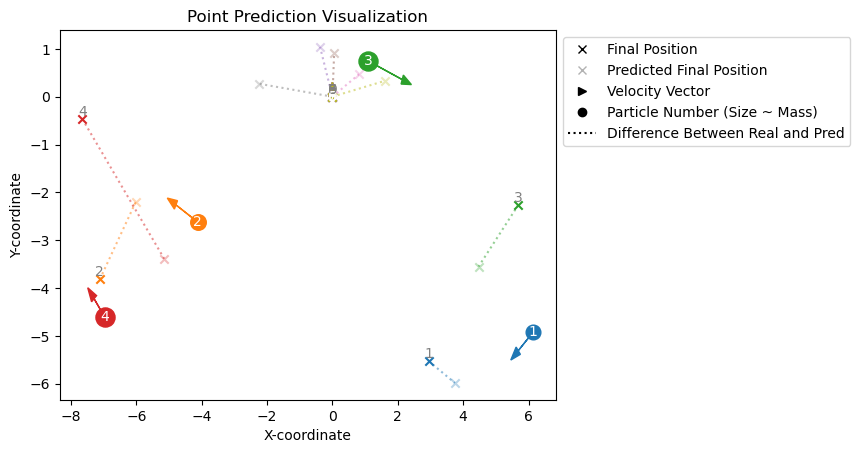

In [139]:
idx = 70

model = model.to("cpu")
out = model(X_train_[idx].unsqueeze(0).float())
out = out.view(-1, 2).detach()


visualize_particles(X_train[idx], y_train[idx], out)

In [140]:
np.set_printoptions(suppress=True)
def constant_baseline(X):
    """ x_t = x_0 """
    predictions = []
    for i in range(len(X)):
        mass, x, y, v_x, v_y = X[i]
        final_coords = [x, y]
        predictions.append(final_coords)
    return np.array(predictions)

def linear_baseline(X, t=5):
    """x_t = x_0 + v_0 * t"""

    predictions = []
    for i in range(len(X)):
        mass, x, y, v_x, v_y = X[i]
        final_coords = [x+v_x*t, y+v_y*t]
        predictions.append(final_coords)
    return np.array(predictions)

def mean_distance_error_bl(output, target):
    distance = []
    target = target.numpy()
    for j in range(9):
        dist = np.linalg.norm(output[j] - target[j])
        distance.append(dist)
    return distance


In [148]:
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [162]:
distances = []
for x, y in train_dataloader:
    x = x.view(9, -1)
    pred = constant_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

distances = []
for x, y in val_dataloader:
    x = x.view(9, -1)
    pred = constant_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

distances = []
for x, y in test_dataloader:
    x = x.view(9, -1)
    pred = constant_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

3.381364011755792
3.395714029885392
3.1510830709032422


In [164]:
distances = []
for x, y in train_dataloader:
    x = x.view(9, -1)
    pred = linear_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

distances = []
for x, y in val_dataloader:
    x = x.view(9, -1)
    pred = linear_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

distances = []
for x, y in test_dataloader:
    x = x.view(9, -1)
    pred = linear_baseline(x)
    truth = y.view(-1, 2)
    distance = mean_distance_error_bl(pred, truth)
    distances.extend(distance)
print(np.mean(distances))

3.479735412533592
3.61052057435392
3.272377248758872


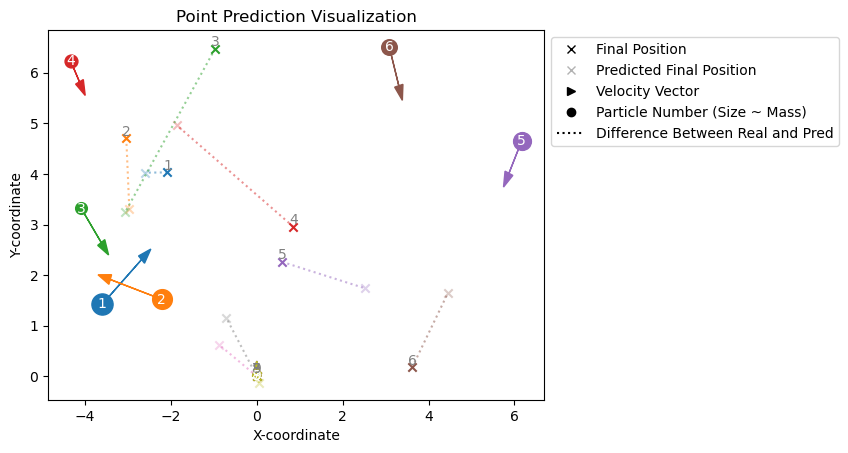

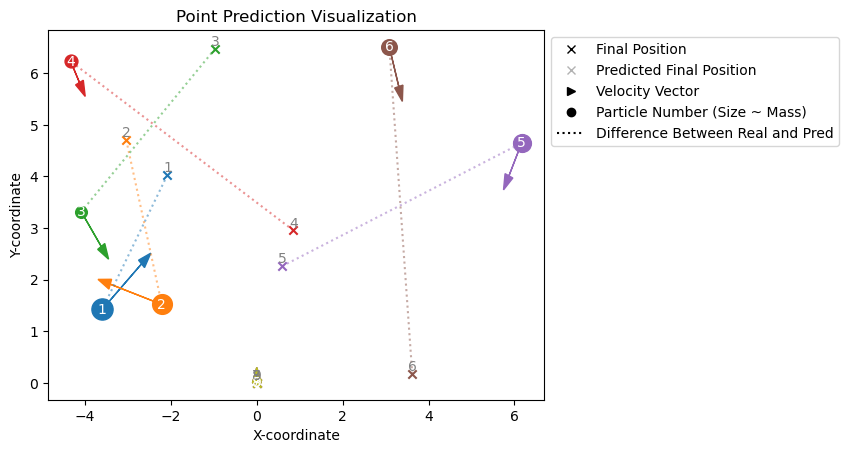

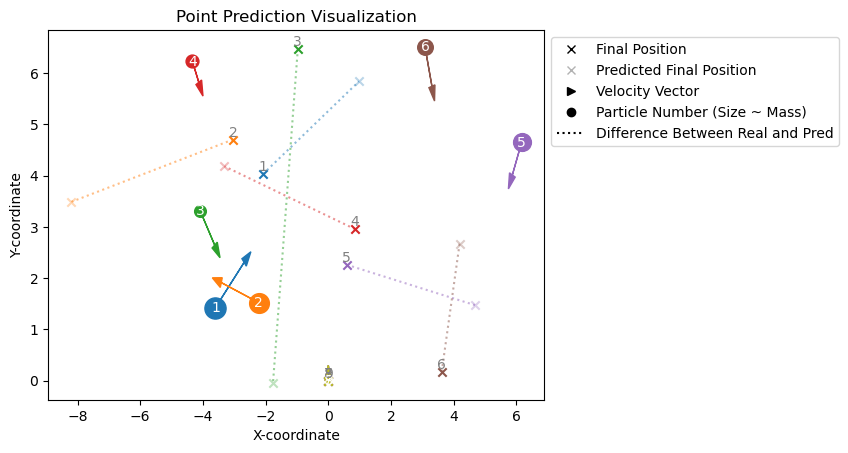

In [219]:
idx = 93

model = model.to("cpu")
out = model(X_train_[idx].unsqueeze(0).float())
out = out.view(-1, 2).detach()
visualize_particles(X_train[idx], y_train[idx], out)

pred = constant_baseline(X_train[idx])
truth = y_train[idx]
visualize_particles(X_train[idx], y_train[idx], pred)
# print(np.mean(mean_distance_error_bl(pred, truth)))

pred = linear_baseline(X_train[idx])
truth = y_train[idx]
visualize_particles(X_train[idx], y_train[idx], pred)
# print(np.mean(mean_distance_error_bl(pred, truth)))

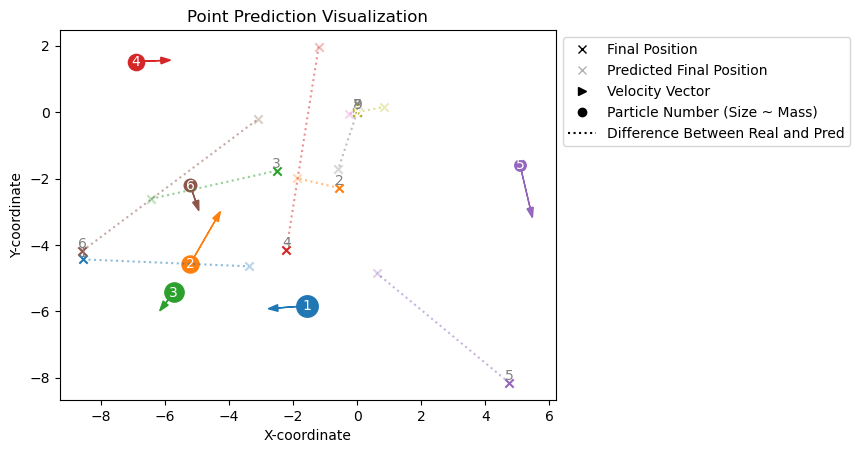

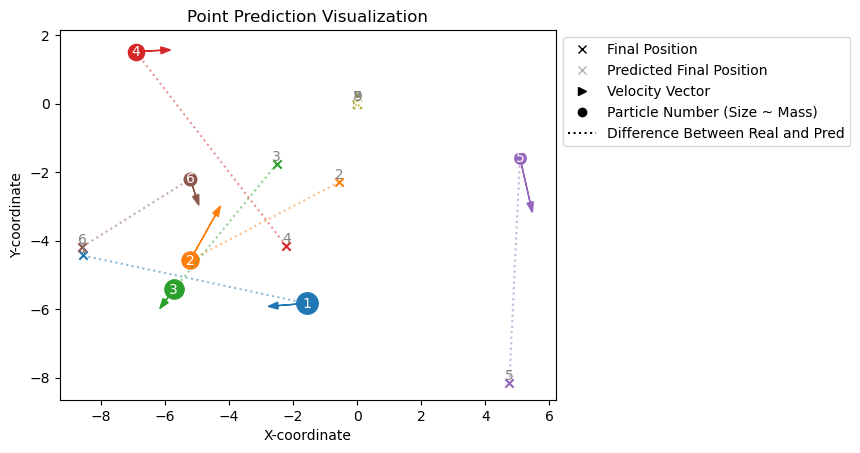

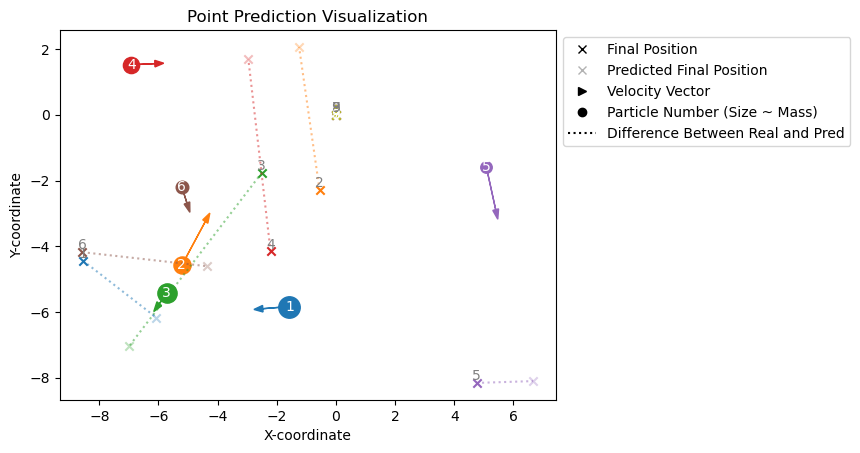

In [204]:
idx = 94

model = model.to("cpu")
out = model(X_test_[idx].unsqueeze(0).float())
out = out.view(-1, 2).detach()
visualize_particles(X_test[idx], y_test[idx], out)

pred = constant_baseline(X_test[idx])
truth = y_test[idx]
visualize_particles(X_test[idx], y_test[idx], pred)
# print(np.mean(mean_distance_error_bl(pred, truth)))

pred = linear_baseline(X_test[idx])
truth = y_test[idx]
visualize_particles(X_test[idx], y_test[idx], pred)
# print(np.mean(mean_distance_error_bl(pred, truth)))

## ALLES HIER BENEDEN NIET NODIG VOOR TASK 1

## Task 2

In [220]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

class ImportData(Dataset):
    def __init__(self, folder_path):
        self.folder_path = folder_path
        self.file_list = sorted(os.listdir(folder_path))

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        file_name = self.file_list[index]
        file_path = os.path.join(self.folder_path, file_name)
        data, label = load_array(file_path, task='task 2')
        return data, label

# Create an instance of the custom dataset class with the folder path
train_import = ImportData(t23_train)
test_import = ImportData(t23_test)

X_train_import = []
y_train_import = []
X_test_import = []
y_test_import = []

# Iterate through the train_dataset to extract data and labels
for data, label in train_import:
    X_train_import.append(data)
    y_train_import.append(label)

for data, label in test_import:
    X_test_import.append(data)
    y_test_import.append(label)

max_length = 9
max_seq = 49

# Pad the data samples with zeros to have the same shape
X_train_padded = []
for data in X_train_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_train_padded.append(padded_data)

y_train_padded = []
for label in y_train_import:
    pad_width = max_length - label.shape[0]
    pad_length = max_seq - label.shape[1]
    padded_label = np.pad(label, ((0, pad_width), (0, pad_length), (0,0)), mode='constant')
    y_train_padded.append(padded_label)

X_test_padded = []
for data in X_test_import:
    pad_width = max_length - data.shape[0]
    padded_data = np.pad(data, ((0, pad_width), (0, 0)), mode='constant')
    X_test_padded.append(padded_data)

y_test_padded = []
for label in y_test_import:
    pad_width = max_length - label.shape[0]
    pad_length = max_seq - label.shape[1]
    padded_label = np.pad(label, ((0, pad_width), (0, pad_length), (0,0)), mode='constant')
    y_test_padded.append(padded_label)

# Convert the padded data and labels to tensors
X_train_first = torch.tensor(np.array(X_train_padded))
y_train_first = torch.tensor(np.array(y_train_padded))
X_train = X_train_first[:700]
y_train = y_train_first[:700]
X_val = X_train_first[700:900]
y_val = y_train_first[700:900]
X_test = torch.tensor(np.array(X_test_padded))
y_test = torch.tensor(np.array(y_test_padded))

X_train_ = X_train.view(700, -1)
y_train_ = y_train.permute(0,2,1,3).reshape(700, 49, -1)
X_val_ = X_val.view(200, -1)
y_val_ = y_val.permute(0,2,1,3).reshape(200, 49, -1)
X_test_ = X_test.view(100, -1)
y_test_ = y_test.permute(0,2,1,3).reshape(100, 49, -1)

# Print the shape of X_train and the first label in y_train
print("X_train shape: ", X_train_.shape)
print("y_train shape: ", y_train_.shape)
print("X_val shape: ", X_val_.shape)
print("y_val shape: ", y_val_.shape)
print("X_test shape: ", X_test_.shape)
print("y_test shape: ", y_test_.shape)

X_train shape:  torch.Size([700, 45])
y_train shape:  torch.Size([700, 49, 36])
X_val shape:  torch.Size([200, 45])
y_val shape:  torch.Size([200, 49, 36])
X_test shape:  torch.Size([100, 45])
y_test shape:  torch.Size([100, 49, 36])


In [221]:
train_dataset = TensorDataset(X_train_, y_train_)
val_dataset = TensorDataset(X_val_, y_val_)
test_dataset = TensorDataset(X_test_, y_test_)

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=9*5, hidden_size=128, num_layers=49, proj_size=36, batch_first=True)
        # self.linear = nn.Linear(128, 45)

    def forward(self, x):
        output, (h_n, c_n) = self.lstm(x)
        # output, (h_n, c_n) = self.linear(output), self.linear(h_n), self.linear(c_n)
        return output, (h_n, c_n)

In [222]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.encoder_mean = nn.Linear(hidden_dim, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, hidden = self.encoder_lstm(x)
        mean = self.encoder_mean(hidden[0])
        logvar = self.encoder_logvar(hidden[0])
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z):
        output, _ = self.decoder_lstm(z)
        output = self.decoder_fc(output)
        return output

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        output = self.decode(z)
        return output, mean, logvar

In [225]:
#Make dataloader
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

model = VAE(45,100,20)
model = model.float()
print(model)

# criterion = euclidean()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

for epoch in range(30):
    # data = create_graph(example1)
    model.train()
    train_loss = 0
    distances = []
    for x, y in train_dataloader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(x.unsqueeze(1).float())  # Perform a single forward pass.
        print(out)
        h_n = h_n.permute(1, 0, 2)
        mask = y != 0
        h_n_ = h_n[mask]
        y_ = y[mask]
        # print(h_n.shape, h_n_.shape)
        loss = criterion(h_n_.float(), y_.float())
        # print(out.shape, y[-1].shape)
        # distance = compute_sum_euclidean(out, y)
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        train_loss += loss
        # distances.append(distance)

    model.eval()
    val_loss = 0
    distances = []
    with torch.no_grad():
        for x, y in val_dataloader:
            out, (h_n, c_n) = model(x.unsqueeze(1).float())  # Perform a single forward pass.
            h_n = h_n.permute(1, 0, 2)
            loss = criterion(h_n.float(), y.float())
            # distance = compute_sum_euclidean(out, y)
            # distances.append(distance)
            val_loss += loss

    print(f'Epoch: {epoch}, TLoss: {train_loss}, VLoss:{val_loss}')

VAE(
  (encoder_lstm): LSTM(45, 100, batch_first=True)
  (encoder_mean): Linear(in_features=100, out_features=20, bias=True)
  (encoder_logvar): Linear(in_features=100, out_features=20, bias=True)
  (decoder_lstm): LSTM(20, 100, batch_first=True)
  (decoder_fc): Linear(in_features=100, out_features=45, bias=True)
)
(tensor([[[ 5.5965e-02, -4.2895e-02,  3.3785e-02,  3.9690e-02, -2.8301e-02,
          -8.4781e-02, -1.2897e-02,  6.5176e-02, -5.3908e-02, -1.1093e-01,
           1.0512e-01, -1.2096e-01,  9.5817e-02,  8.4003e-02,  4.4371e-02,
          -6.6528e-02, -6.3402e-02,  3.9087e-02, -7.9381e-02, -2.4358e-02,
          -4.0148e-02, -6.4028e-02, -2.2359e-03,  9.4246e-02,  2.3184e-02,
           6.2264e-03, -3.3511e-02,  3.7586e-02,  2.2948e-02,  9.3854e-02,
          -8.7560e-02, -3.5392e-02,  6.4445e-02,  7.9390e-02,  6.8808e-02,
           9.9785e-02,  3.6231e-02,  8.6053e-02, -7.8580e-02, -2.0147e-02,
           8.6464e-02, -1.1701e-02,  8.3099e-02,  4.1719e-02,  8.5534e-02],
      

NameError: name 'h_n' is not defined

In [ ]:
x, y = next(iter(train_dataloader))
o, (h, c) = model(x.unsqueeze(1).float())
h = h.permute(1, 0, 2)
o

In [279]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define the Variational Autoencoder (VAE) with LSTM
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim,  batch_first=True)
        self.encoder_mean = nn.Linear(hidden_dim, latent_dim)
        self.encoder_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder_lstm = nn.LSTM(latent_dim, hidden_dim, batch_first=True)
        self.decoder_fc = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        _, hidden = self.encoder_lstm(x)
        mean = self.encoder_mean(hidden[0])
        logvar = self.encoder_logvar(hidden[0])
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z):
        output, _ = self.decoder_lstm(z)
        output = self.decoder_fc(output)
        return output

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        output = self.decode(z)
        return output, mean, logvar


input_dim = 45
hidden_dim = 100
latent_dim = 16
lr = 0.01
batch_size = 32
num_epochs = 10

model = VAE(input_dim, hidden_dim, latent_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    total_loss = 0

    for x, y in train_dataloader:
        optimizer.zero_grad()
        inputs = x.float()
        outputs, mean, logvar = model(inputs)
        reconstruction_loss = criterion(outputs, inputs)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())
        loss = reconstruction_loss + kl_divergence
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}, Loss: {average_loss}")

Epoch 1, Loss: 7.694702408530495
Epoch 2, Loss: 6.989716941660101
Epoch 3, Loss: 6.8154307495463975
Epoch 4, Loss: 6.745412674817172
Epoch 5, Loss: 6.746850989081643
Epoch 6, Loss: 6.737785512750799
Epoch 7, Loss: 6.738112449645996
Epoch 8, Loss: 6.729852871461348
Epoch 9, Loss: 6.72849102453752
Epoch 10, Loss: 6.727160562168468


In [310]:
X_train[:32]

tensor([[[ 4.5467e+00, -5.2712e+00,  5.0786e+00, -1.0969e+00, -3.6693e+00],
         [ 3.5751e+00,  4.3271e+00, -8.0950e-02, -5.7869e-01, -2.9597e+00],
         [ 2.6773e+00, -5.1597e+00,  5.3524e+00,  2.4265e+00,  1.4587e+00],
         ...,
         [ 3.0312e+00, -5.0562e-01,  1.5046e+01, -9.4773e-01,  1.4981e+01],
         [ 4.1353e+00,  1.8134e+00,  3.8438e+00, -6.9897e-01, -2.2509e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.6937e+00,  2.0766e+00,  1.0946e+00, -1.1010e+00, -2.2900e+00],
         [ 1.8962e+00, -3.1039e+00, -4.7018e+00, -1.2210e+00,  6.3255e-01],
         [ 2.7207e+00,  4.9868e+00, -5.2032e+00, -1.1111e+00, -1.2724e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.1448e+00,  7.6558e+00,  5.8251e+00,  6.8194

In [311]:
x.view(-1, 9, 5)

tensor([[[ 4.5467e+00, -5.2712e+00,  5.0786e+00, -1.0969e+00, -3.6693e+00],
         [ 3.5751e+00,  4.3271e+00, -8.0950e-02, -5.7869e-01, -2.9597e+00],
         [ 2.6773e+00, -5.1597e+00,  5.3524e+00,  2.4265e+00,  1.4587e+00],
         ...,
         [ 3.0312e+00, -5.0562e-01,  1.5046e+01, -9.4773e-01,  1.4981e+01],
         [ 4.1353e+00,  1.8134e+00,  3.8438e+00, -6.9897e-01, -2.2509e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 2.6937e+00,  2.0766e+00,  1.0946e+00, -1.1010e+00, -2.2900e+00],
         [ 1.8962e+00, -3.1039e+00, -4.7018e+00, -1.2210e+00,  6.3255e-01],
         [ 2.7207e+00,  4.9868e+00, -5.2032e+00, -1.1111e+00, -1.2724e-01],
         ...,
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00]],

        [[ 3.1448e+00,  7.6558e+00,  5.8251e+00,  6.8194

In [312]:
y_train[:32]

tensor([[[[-5.3508e+00,  4.7698e+00, -6.0152e-01, -2.7740e+00],
          [-5.3998e+00,  4.5065e+00, -3.9563e-01, -2.5268e+00],
          [-5.4322e+00,  4.2605e+00, -2.6088e-01, -2.4050e+00],
          ...,
          [-5.7966e-01, -4.2417e+00,  1.7654e+00, -4.3593e+00],
          [-3.8407e-01, -4.6990e+00,  2.1710e+00, -4.7872e+00],
          [-1.4081e-01, -5.1981e+00,  2.7102e+00, -5.1801e+00]],

         [[ 4.2678e+00, -3.7542e-01, -6.0709e-01, -2.9297e+00],
          [ 4.2057e+00, -6.6690e-01, -6.3489e-01, -2.8997e+00],
          [ 4.1408e+00, -9.5535e-01, -6.6210e-01, -2.8695e+00],
          ...,
          [-6.8549e-01, -9.6195e+00, -1.2635e+00, -4.5688e-01],
          [-8.1063e-01, -9.6572e+00, -1.2388e+00, -2.9466e-01],
          [-9.3314e-01, -9.6777e+00, -1.2110e+00, -1.1257e-01]],

         [[-4.9651e+00,  5.3952e+00,  1.6454e+00, -1.4977e-01],
          [-4.8168e+00,  5.3516e+00,  1.3514e+00, -6.6711e-01],
          [-4.6911e+00,  5.2681e+00,  1.1729e+00, -9.8257e-01],
      

In [313]:
y.reshape(-1, 49, 9, 4).permute(0, 2, 1, 3)

tensor([[[[-5.3508e+00,  4.7698e+00, -6.0152e-01, -2.7740e+00],
          [-5.3998e+00,  4.5065e+00, -3.9563e-01, -2.5268e+00],
          [-5.4322e+00,  4.2605e+00, -2.6088e-01, -2.4050e+00],
          ...,
          [-5.7966e-01, -4.2417e+00,  1.7654e+00, -4.3593e+00],
          [-3.8407e-01, -4.6990e+00,  2.1710e+00, -4.7872e+00],
          [-1.4081e-01, -5.1981e+00,  2.7102e+00, -5.1801e+00]],

         [[ 4.2678e+00, -3.7542e-01, -6.0709e-01, -2.9297e+00],
          [ 4.2057e+00, -6.6690e-01, -6.3489e-01, -2.8997e+00],
          [ 4.1408e+00, -9.5535e-01, -6.6210e-01, -2.8695e+00],
          ...,
          [-6.8549e-01, -9.6195e+00, -1.2635e+00, -4.5688e-01],
          [-8.1063e-01, -9.6572e+00, -1.2388e+00, -2.9466e-01],
          [-9.3314e-01, -9.6777e+00, -1.2110e+00, -1.1257e-01]],

         [[-4.9651e+00,  5.3952e+00,  1.6454e+00, -1.4977e-01],
          [-4.8168e+00,  5.3516e+00,  1.3514e+00, -6.6711e-01],
          [-4.6911e+00,  5.2681e+00,  1.1729e+00, -9.8257e-01],
      

In [314]:
x, y = next(iter(train_dataloader))
pred, mu, var = model(x.float())
pred

tensor([[ 3.3839,  0.2794,  0.1445, -0.0858, -0.0240,  3.3987, -0.0952,  0.1470,
         -0.0515, -0.0852,  3.3817, -0.3170,  0.2519,  0.0667,  0.1327,  3.2461,
          0.2852, -0.6087, -0.0772, -0.1334,  2.8250, -0.0296,  0.1866,  0.0308,
          0.2130,  2.3392,  0.1778, -0.1494,  0.1955,  0.0179,  1.5676, -0.0600,
          0.2169, -0.0057,  0.0234,  1.0280, -0.1745, -0.0634,  0.0820,  0.0481,
          0.6726,  0.1054, -0.1230, -0.0861, -0.0411]],
       grad_fn=<AddmmBackward0>)

GCN

In [352]:
def linear_sequence_baseline(X, t=49):
    predictions = []
    for i in range(len(X)):
        seq = []
        for j in range(t):
            outp = linear_baseline([X[i]], ((j+1)*0.1))[0]
            seq.append(list(outp))
        predictions.append(seq)
    return np.array(predictions)

def constant_sequence_baseline(X, t=49):
    predictions = []
    for i in range(len(X)):
        seq = []
        for j in range(t):
            outp = constant_baseline([X[i]])[0]
            seq.append(list(outp))
        predictions.append(seq)
    return np.array(predictions)

def obtain_coords(y):
    truth = []
    for i in range(len(y)):
        seq = []
        for j in range(len(y[i])):
            seq.append([y[i][j][0], y[i][j][1]])
        truth.append(seq)
    return np.array(truth)

In [353]:
def average_summed_euclidean_distance(pred, truth):
    pred = np.array(pred)
    truth = np.array(truth)
    distance = []
    for i in range(9):
        dist = sum(np.linalg.norm(pred[i] - truth[i], axis=1))
        distance.append(dist)
    return distance

In [354]:
distances = []
for i in range(len(X_train)):
    pred = linear_sequence_baseline(X_train[i])
    truth = obtain_gt(y_train[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

distances = []
for i in range(len(X_val)):
    pred = linear_sequence_baseline(X_val[i])
    truth = obtain_gt(y_val[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

distances = []
for i in range(len(X_test)):
    pred = linear_sequence_baseline(X_test[i])
    truth = obtain_gt(y_test[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

76.29453585282452
73.82794770205413
83.27127453025093


In [355]:
distances = []
for i in range(len(X_train)):
    pred = constant_sequence_baseline(X_train[i])
    truth = obtain_gt(y_train[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

distances = []
for i in range(len(X_val)):
    pred = constant_sequence_baseline(X_val[i])
    truth = obtain_gt(y_val[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

distances = []
for i in range(len(X_test)):
    pred = constant_sequence_baseline(X_test[i])
    truth = obtain_gt(y_test[i])
    error = average_summed_euclidean_distance(pred, truth)
    distances.extend(error)
print(np.mean(distances))

89.46990763625655
84.29957375469036
95.03258962659146


In [ ]:
# from torch_geometric.nn import DenseGCNConv
# from torch_geometric.utils import to_dense_adj

# class GCN(torch.nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.conv1 = DenseGCNConv(-1, 32)
#         self.conv2 = DenseGCNConv(32, 64)
#         self.linear = Linear(64, 2)

#     def forward(self, x, edge_index, edge_weight=None):
#         # x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv1(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
#         # x = F.dropout(x, p=0.5, training=self.training)
#         x = self.conv2(x, edge_index, edge_weight)
#         x = F.leaky_relu(x)
#         x = self.linear(x)
#         return x

In [ ]:
# def train(lst):
#     model.train()
#     running_loss = 0
#     distances = []
#     for data in lst:
#         optimizer.zero_grad()  # Clear gradients.
#         adj = to_dense_adj(data.edge_index)
#         out = model(data.x.float(), adj)  # Perform a single forward pass.
#         loss = criterion(out.float(), data.y.float())
#         # print(out,data.y)
#         try:
#             distance = compute_sum_euclidean(out, data.y)
#         except:
#           distance = 0
#         loss.backward()  # Derive gradients.
#         optimizer.step()  # Update parameters based on gradients.

#         running_loss += loss
#         distances.append(distance)

#     return running_loss, np.mean(distances)

# def evaluate(lst):
#     model.eval()
#     running_loss = 0
#     distances = []
#     with torch.no_grad():
#         for data in lst:
#             out = model(data.x.float())  # Perform a single forward pass.
#             loss = criterion(out.float(), data.y.float())
#             distance = compute_sum_euclidean(out, data.y)
#             distances.append(distance)
#             running_loss += loss
#     return running_loss, np.mean(distances)

In [ ]:
# model = GCN()
# # criterion = euclidean()
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# # optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# for epoch in range(100):
#     # data = create_graph(example1)
#     loss, dist = train(train_graphs_lst[:1])
#     print(f'Epoch: {epoch}, Loss: {loss}, Summed distance: {dist}')

In [ ]:
# class euclidean(torch.nn.Module): # forgot to define backward()
#     def forward(self, output, target):
#         loss = torch.norm(output-target)
#         return loss



In [ ]:
# data = train_graphs_lst[0]
# adj = to_dense_adj(data.edge_index)
# model(data.x.float(), adj)

In [ ]:
#todo

In [ ]:
# import torch
# from torch.utils.data import Dataset, DataLoader
# from torch_geometric.data import Data


# # Function to process a single data point
# def create_graph(data_point, label):

#     #Create node features
#     node_features = data_point  # Exclude the mass column

#     # Compute edge indices
#     edge_indices = []
#     for i in range(9):
#         for j in range(9):
#             if i != j:
#                 edge_indices.append([i, j])
#     edge_indices = torch.tensor(edge_indices).t().contiguous()

#     # Compute edge features
#     edge_features = []
#     for i in range(9):
#         for j in range(9):
#             if i != j:
#                 pos = node_features[j] - node_features[i]

#                 # Calculate Euclidean distance
#                 # pos = torch.tensor(pos)
#                 relative_position = torch.norm(pos)
#                 # print("Relative position: ", relative_position)

#                 relative_mass = node_features[j, 0] / node_features[i, 0]
#                 if relative_mass == np.inf or relative_mass == 0:
#                     relative_position = 0
#                     relative_mass = 0
#                 # relative_mass = torch.tensor(relative_mass)
#                 # print("Relative mass: ", relative_mass)
#                 edge_features.append([relative_position, relative_mass])
#                 # edge_features.append(torch.cat((relative_position, torch.tensor([relative_mass], dtype=torch.float32))))
#     edge_features = torch.FloatTensor(edge_features)

#     data = Data(x=node_features, edge_index=edge_indices, edge_attr=edge_features, y=label)

#     return data

In [ ]:
# pip install torch_geometric


In [ ]:
# create_graph(X_train[0], y_train[0])

In [ ]:
# len(X_train)

In [ ]:
evaluate(train_graphs_lst), evaluate(test_graphs_lst)

In [ ]:
# train_graphs_lst = []
# val_graphs_lst = []
# test_graphs_lst = []

# for i in range(len(X_train)):
#     if i < 700:
#         train_graphs_lst.append(create_graph(X_train[i], y_train[i]))
#     else:
#         val_graphs_lst.append(create_graph(X_train[i], y_train[i]))

# for i in range(len(X_test)):
#     test_graphs_lst.append(create_graph(X_test[i], y_test[i]))



In [ ]:
# def create_edge(length, i):
#     lst1 = []
#     lst1.extend([i]*(length-1))
#     lst2 = []
#     for j in range(length):
#         if i != j:
#             lst2.append(j)
#     return np.array([lst2, lst1])

# def create_edges(length):
#     lst1 = []
#     for i in range(length):
#         lst1.extend([i]*(length-1))
#     lst2 = []
#     for i in range(length):
#         for j in range(length):
#             if i != j:
#                 lst2.append(j)
#     return np.array([lst1, lst2])

# create_edges(10)

In [ ]:
# import torch
# from torch_geometric.data import Data
# def create_graph(array):
#     num_nodes = len(array[1])
#     edge_indexes = torch.tensor(create_edges(num_nodes), dtype=torch.long)
#     data = Data(x=torch.tensor(array[0], dtype=torch.double),
#                 edge_index=edge_indexes,
#                 y=torch.tensor(array[1]))
#     return data

# def create_graphs(array):
#     lst = []
#     num_nodes = len(array[1])
#     for i in range(num_nodes):
#         edge_indexes = torch.tensor(create_edge(num_nodes, i), dtype=torch.long)
#         data = Data(x=torch.tensor(array[0], dtype=torch.double),
#                     edge_index=edge_indexes,
#                     y=torch.tensor(array[1][i]))
#         lst.append(data)
#     return lst

# data = create_graphs(example1)
# data

In [ ]:
# import networkx as nx
# from torch_geometric.utils import to_networkx
# g = to_networkx(data[0], to_undirected=False)
# nx.draw(g)

In [ ]:
class LSTM_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=5, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 2)

    def forward(self, x):
        x, _ = self.lstm(x)
        # print(_[1].shape)
        x = self.linear(x)
        return x